In [4]:
import os
import sys
import pandas as pd
import numpy as np
import gget
import scipy
import time
from scipy.sparse import csr_matrix
import anndata as an
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# local imports
import anndata_utils as anntools

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import centrality as central
import matrix
import utils as ut
import plotting as plt2

# load ann data

In [7]:
resolution = 1000000
population_path = f"/scratch/indikar_root/indikar1/shared_data/higher_order/lightweight/population_mESC_{resolution}_anndata.h5ad"

start_time = time.time()  # Record the start time
adata = sc.read_h5ad(population_path)
end_time = time.time()  # Record the end time
print(f"Time taken to read the file: {end_time - start_time:.2f} seconds")
sc.logging.print_memory_usage()

# sort the object by global bin id
sorted_indices = adata.obs['bin'].argsort()
adata = adata[sorted_indices, :] 

adata

Time taken to read the file: 5.69 seconds
Memory usage: current 2.44 GB, difference +0.86 GB


View of AnnData object with n_obs × n_vars = 2579 × 2756467
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'PolII'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes'
    uns: 'base_resolution', 'chrom_sizes'

# Load Core Scores

In [8]:
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/global_core_score/population_mESC_1000000_scores.csv"
df = pd.read_csv(fpath)
print(f"{df.shape=}")

columns_to_drop = [x for x in df.columns if x in adata.obs.columns]
df = df.drop(columns=columns_to_drop)
print(f"{df.shape=}")

adata.obs = pd.merge(
    adata.obs, df.set_index('bin_name'),
    how='left',
    left_index=True,
    right_index=True,
)

adata.obs.head()

df.shape=(2431, 36)
df.shape=(2431, 15)


,bin_index,bin_start,bin_end,bin,chrom,chrom_bin,degree,genes,n_genes,ATACSeq_1,...,ce_betweenness_centrality,ce_pagerank,hge_singular_vector_1,hge_logexp_unweighted,hge_logexp_degree_weighted,hge_logexp_RNA_weighted,hge_logexp_ATAC_weighted,global_singular_vector_1,global_hge_logexp_unweighted,global_hge_logexp_RNA_weighted
bin_name,,,,,,,,,,,,,,,,,,,,,
chr1:3,2235,3000000,4000000,3,1,3,2953,Xkr4;Gm38148;Gm37329;Gm37381;Gm38385;Gm37180;G...,15,0.507852,...,0.671480,0.117995,0.000000,0.148099,0.000000,0.174370,0.222380,0.330855,0.501567,0.167764
chr1:4,964,4000000,5000000,4,1,4,3331,Gm38076;Gm6123;Gm37587;Gm6104;Gm7369;Gm6119;A9...,22,0.680719,...,0.267148,0.372869,0.103845,0.239187,0.281148,0.468270,0.560302,0.412235,0.609261,0.369136
chr1:5,1823,5000000,6000000,5,1,5,3341,Gm37429;Npbwr1;Oprk1;Gm7182;Gm37567;Rgs20;Atp6...,12,0.567134,...,0.109507,0.224249,0.057865,0.647027,0.201096,0.243125,0.405148,0.425601,0.528269,0.216383
chr1:6,1288,6000000,7000000,6,1,6,3422,Gm2147;Alkal1;Gm37108;Gm7449;St18;4732440D04Ri...,10,0.621495,...,0.009627,0.534940,0.172229,0.760979,0.401754,0.250762,0.521777,0.448264,0.492633,0.258762
chr1:7,144,7000000,8000000,7,1,7,3289,Gm7470;Gm37791;Gm57122;Gm19002;Gm38216;Gm23274...,18,0.497991,...,0.252708,0.099600,0.053319,0.000000,0.160235,0.190846,0.204818,0.414267,0.510526,0.204855


In [11]:
adata.obs.columns

Index(['bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin',
       'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3',
       'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4',
       'RNA_5', 'RNA_6', 'PolII', 'degree_outlier', 'chrom_degree',
       'ce_singular_vector_1', 'ce_eigenvector_centrality',
       'ce_betweenness_centrality', 'ce_pagerank', 'hge_singular_vector_1',
       'hge_logexp_unweighted', 'hge_logexp_degree_weighted',
       'hge_logexp_RNA_weighted', 'hge_logexp_ATAC_weighted',
       'global_singular_vector_1', 'global_hge_logexp_unweighted',
       'global_hge_logexp_RNA_weighted'],
      dtype='object')

<Axes: >

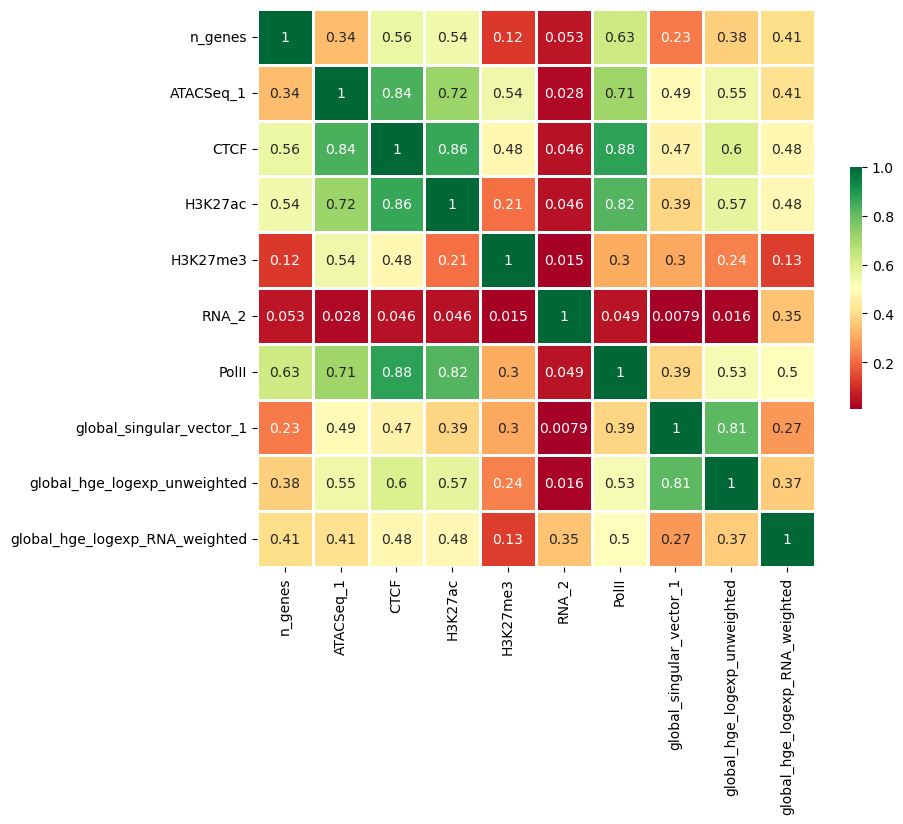

In [27]:
columns = [
    'n_genes',
    'ATACSeq_1',
    'CTCF',
    'H3K27ac', 
    'H3K27me3',
    'RNA_2',  
    'PolII',
    'global_singular_vector_1',
    'global_hge_logexp_unweighted',
    'global_hge_logexp_RNA_weighted',
]

A = adata.obs[columns].corr()

plt.rcParams['figure.figsize'] = 9, 9

sns.heatmap(
    A,
    cmap='RdYlGn',
    lw=1,
    square=True,
    annot=True,
    cbar_kws={'shrink':0.35}
)

# Expression Table

In [31]:
# load the expression data 
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/expression_table/rna_table.parquet"

columns = [
    'ens_gene_id',
    'TPM',
    'FPKM',
    'effective_length',
]

df = pd.read_parquet(fpath, columns=columns)
print(f"{df.shape=}")
df.head()

# load the gene annotations
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/reference/gene_table.parquet"
gdf = pd.read_parquet(fpath)
print(f"{gdf.shape=}")
gdf.head()

df.shape=(51883, 5)
gdf.shape=(56655, 10)


,gene_id,gene_name,gene_source,gene_biotype,Chromosome,Start,End,length,midpoint,is_tf
0,ENSMUSG00000104478,Gm38212,havana,TEC,1,108344806,108347562,2756,108346184,False
1,ENSMUSG00000104385,Gm7449,havana,processed_pseudogene,1,6980783,6981446,663,6981114,False
2,ENSMUSG00000102135,Gm37108,havana,processed_pseudogene,1,6986782,6993812,7030,6990297,False
3,ENSMUSG00000103282,Gm37275,havana,processed_pseudogene,1,6999982,7000012,30,6999997,False
4,ENSMUSG00000101097,Gm6679,havana,processed_pseudogene,1,108697864,108699733,1869,108698798,False
